Running YOLO object detection...

0: 640x480 1 main-top, 32.4ms
Speed: 4.0ms preprocess, 32.4ms inference, 162.8ms postprocess per image at shape (1, 3, 640, 480)
YOLO detected 1 objects.


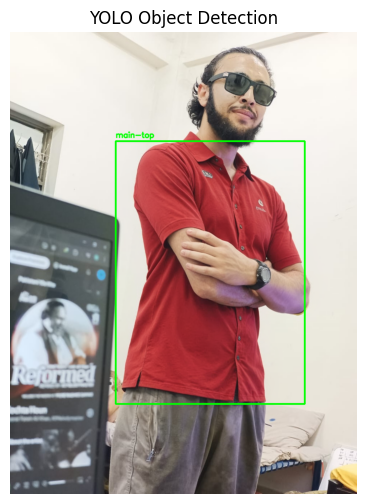

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv8 model
yolo_model = YOLO("D:\Github\AI\Computer Vision\Object Detection Project Igi 1\ChangeMyclothes\models\FashionYololast.pt")  # Change to your trained YOLO model

# Load input image
image_path = r"D:\Github\AI\Computer Vision\Object Detection Project Igi 1\ChangeMyclothes\Generate\result_1740578315.png"  # Change this to your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 1: Object Detection using YOLO
print("Running YOLO object detection...")
results = yolo_model(image_rgb, conf=0.6)

# Extract bounding boxes and labels
bboxes = []
labels = []
image_with_bboxes = image_rgb.copy()

for result in results:
    for box, cls in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy()):
        bboxes.append(box)
        labels.append(int(cls))  # Convert class index to integer

# Get class names from the model
class_names = yolo_model.names

print(f"YOLO detected {len(bboxes)} objects.")

# Draw bounding boxes with labels on image
for bbox, label in zip(bboxes, labels):
    x1, y1, x2, y2 = map(int, bbox)
    class_name = class_names[label]  # Get class name
    cv2.rectangle(image_with_bboxes, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # Add text label
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image_with_bboxes, class_name, (x1, y1 - 10), font, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

# Show detection results
plt.figure(figsize=(8, 6))
plt.imshow(image_with_bboxes)
plt.title("YOLO Object Detection")
plt.axis("off")
plt.show()

# Save bounding boxes for next step
np.save("bboxes.npy", np.array(bboxes))


Running SAM segmentation...


Processing SAM Segmentation: 100%|██████████| 2/2 [00:02<00:00,  1.34s/bbox]


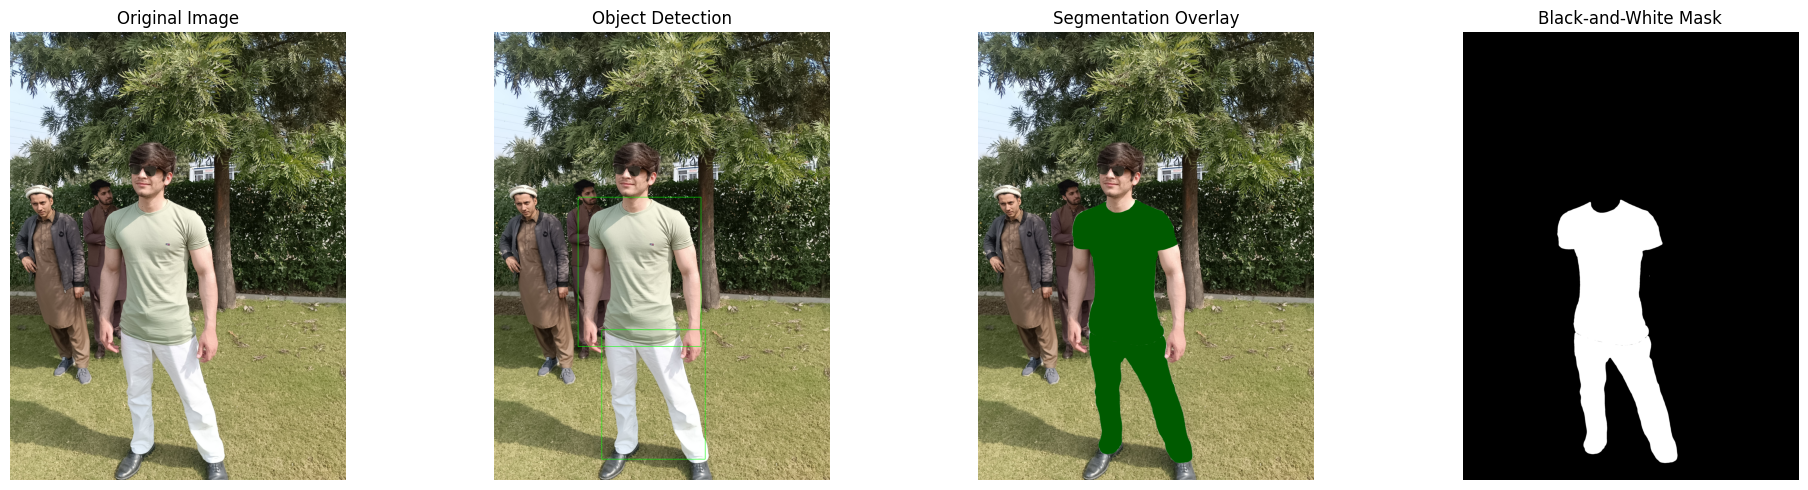

In [9]:
from tqdm import tqdm
from segment_anything import SamPredictor, sam_model_registry

# Load SAM model
sam_checkpoint = "sam_vit_l_0b3195.pth"  # Ensure you have this checkpoint
sam = sam_model_registry["vit_l"](checkpoint="sam_vit_l_0b3195.pth").to("cuda" if torch.cuda.is_available() else "cpu")

sam_predictor = SamPredictor(sam)

# Reload image
image_rgb = cv2.cvtColor(cv2.imread("image0.jpg"), cv2.COLOR_BGR2RGB)

# Load saved bounding boxes
bboxes = np.load("bboxes.npy")

# Step 2: Segment objects using SAM
print("Running SAM segmentation...")
sam_predictor.set_image(image_rgb)

masks = []
bw_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)

for i, bbox in enumerate(tqdm(bboxes, desc="Processing SAM Segmentation", unit="bbox")):
    x1, y1, x2, y2 = map(int, bbox)
    input_box = np.array([x1, y1, x2, y2])
    
    # Run SAM
    mask, _, _ = sam_predictor.predict(box=input_box, multimask_output=False)
    masks.append(mask[0])  # Store the segmentation mask
    
    # Update black-and-white mask
    bw_mask[mask[0]] = 255

# Step 3: Overlay segmentation on image
overlay = image_rgb.copy()
for mask in masks:
    overlay[mask] = (0, 90, 0)  # Green overlay for segmented area

# Step 4: Display results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")

axes[1].imshow(image_with_bboxes)
axes[1].set_title("Object Detection")

axes[2].imshow(overlay)
axes[2].set_title("Segmentation Overlay")

axes[3].imshow(bw_mask, cmap="gray")
axes[3].set_title("Black-and-White Mask")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
cv2.imwrite("mask.png", cv2.cvtColor(bw_mask, cv2.COLOR_RGB2BGR))


True

In [11]:
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time

In [12]:
# !#@title Connect to the Stability API

import getpass
# @markdown To get your API key visit https://platform.stability.ai/account/keys
STABILITY_KEY = getpass.getpass('Enter your API Key')



In [13]:
#@title Define functions

def send_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        print(f"Polling results at https://api.stability.ai/v2beta/results/{generation_id}")
        response = requests.get(
            f"https://api.stability.ai/v2beta/results/{generation_id}",
            headers={
                **headers,
                "Accept": "*/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

In [16]:
#@title Inpaint

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "image0.jpg" #@param {type:"string"}
mask = "mask.png" #@param {type:"string"}
prompt = "white shirt , red coat " #@param {type:"string"}
negative_prompt = " Not higer then 9,437,184 pixels  , normal quality (720*720)" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/inpaint"

params = {
    "image" : image,
    "mask" : mask,
    "negative_prompt" : negative_prompt,
    "seed" : seed,
    "mode": "mask",
    "output_format": output_format,
    "prompt" : prompt
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

# output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

Sending REST request to https://api.stability.ai/v2beta/stable-image/edit/inpaint...


Exception: HTTP 400: {"errors":["image: unsupported dimensions - must be at most 9,437,184 pixels, received 12,975,040 pixels","mask: unsupported dimensions - must be at most 9,437,184 pixels, received 12,975,040 pixels"],"id":"12920b70b6c0720f83be495987cbb66a","name":"bad_request"}